# Sugarscape

## Life and Death on the Sugarscape
After Growing Articifical Societies - Social Science from the Bottom Up by Joshua Epstein and Robert Axtell

We follow chapter II of the book and model the simplest case, adding features as we go along.

In [1]:
# We define an abstract type AgentInfo with two subtypes: NoAgent and Agent.
# This allows for removing an agent from the board while keeping his entry in the agent list.
# Also it allows for recursive type definition, an unresolved issue in Julia #269
abstract AgentInfo

type NoAgent <: AgentInfo
end

In [2]:
type Place
    x::Int
    y::Int
    agent::AgentInfo
    sugar::Int
    capacity::Int
end

In [3]:
type Agent <: AgentInfo
    place::Place
    vision::Int
    metabolism::Int
    stash::Int
end

In [4]:
# To keep record of the simulation, we keep all agent steps in memory for now
# Alternatively, only the current agent list could be kept or all agents with
# the lattice at each point.
type AgentList
    agents::Vector{AgentInfo}
end

type Scape
    lattice::Array{Place}
    steps::Vector{AgentList}
end

In [5]:
# convenience functions
agents(Scape) = last(Scape.steps).agents

agents (generic function with 1 method)

### World map

In [6]:
# We define sugarscape capacity similar to graphs in the book
function init_capacity()
    grid = 50
    hump1 = [15, 15]
    hump2 = [40, 40]
    dist(xy, hump) = hypot(xy[1]-hump[1], xy[2]-hump[2])
    capacity = Int[max(0, 4 - ifloor(min(dist([i,j], hump1), dist([i,j], hump2))/5)) for i=1:grid,j=1:grid]
end

init_capacity (generic function with 1 method)

In [7]:
using PyPlot

INFO: Loading help data...


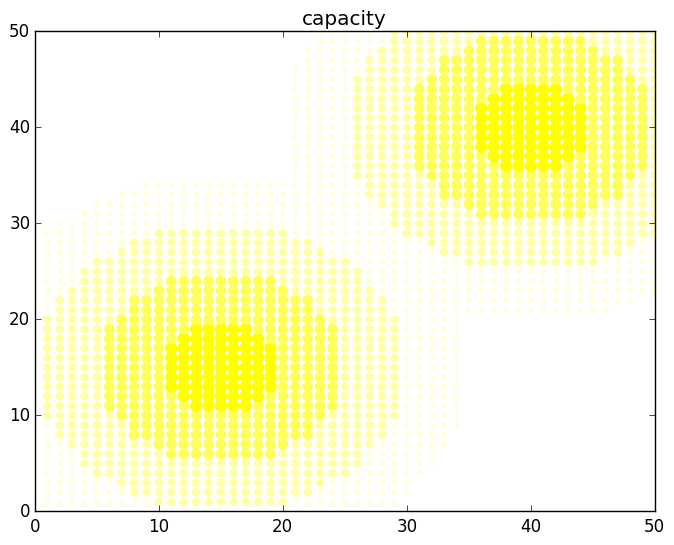

PyObject <matplotlib.text.Text object at 0x0000000002CD0240>

In [8]:
#plot capacity (not yet in lattice)
capacity = init_capacity()
cm = ColorMap([Color.RGB(1,1,1), Color.RGB(1,1,0)],5,1.5)
ind_i, ind_j = collect(ind2sub(size(capacity),1:length(capacity)))
scatter(ind_i, ind_j,s=capacity*20, c=capacity,cmap=cm,marker="o",lw=0)

xlim(0, 50); ylim(0, 50)
title("capacity")

In [9]:
using StatsBase: sample

In [15]:
function init_scape(capacity; N_agents=400)
    gridx, gridy = size(capacity)
    # create empty lattice with sugar levels at full capacity
    lattice = [Place(i,j, NoAgent(), capacity[i,j], capacity[i,j]) for i=1:gridx, j=1:gridy]

    #populate with agents
    agents = AgentInfo[]
    for place in sample(lattice, N_agents, replace=false)
        vision = rand(1:6)
        metabolism = rand(1:4)
        stash = 0
        agent = Agent(place, vision, metabolism, stash)
        push!(agents, agent)

        place.agent = agent
    end
    
    Scape(lattice, [AgentList(agents)])
end

init_scape (generic function with 1 method)

In [19]:
@time scape = init_scape(init_capacity());

elapsed time: 0.000864824 seconds (721176 bytes allocated)


In [20]:
# convenience functions to retrieve only alive agents
alive(agent::AgentInfo) = isa(agent, Agent)    

function living(scape)
    allagents = agents(scape)
    allagents[map(alive, allagents)]
end

living (generic function with 1 method)

Let's also define scape plotting

In [22]:
function plot(scape::Scape)
    lattice = scape.lattice
    gridx, gridy = size(lattice)
    sugar = reshape([p.sugar for p in lattice], gridx, gridy)
    s_i, s_j = collect(ind2sub(size(lattice), 1:length(lattice)))
    colmap = ColorMap([Color.RGB(1,1,1), Color.RGB(1,1,0)],5,1.5)
    PyPlot.scatter(s_i, s_j, s=20*sugar, c=sugar, cmap=cm, marker="o", lw=0)

    a_i = [a.place.x for a in living(scape)]
    a_j = [a.place.y for a in living(scape)]
    scatter(a_i, a_j, c="red", lw=0)
    gridx
    xlim(0, gridx+1); ylim(0, gridy+1)
    title("Sugarscape step $(length(scape.steps))")
end

plot (generic function with 1 method)

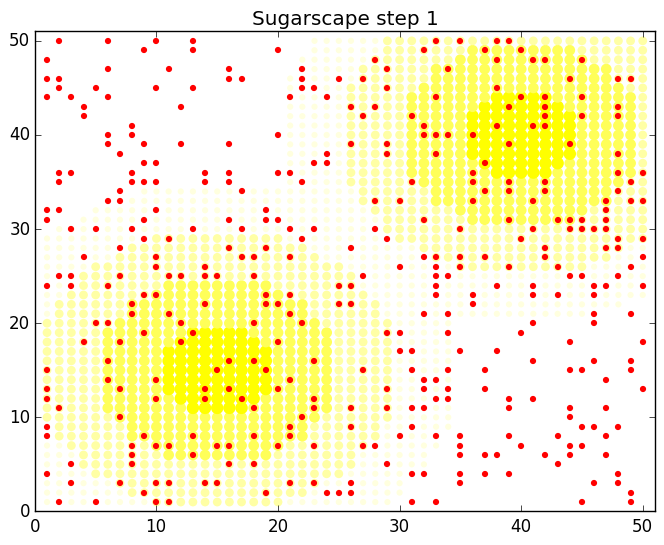

PyObject <matplotlib.text.Text object at 0x0000000002D93400>

In [23]:
plot(scape)

In [24]:
pygui(true)

true

In [26]:
@time plot(scape)

elapsed time: 0.022803147 seconds (279544 bytes allocated)


PyObject <matplotlib.text.Text object at 0x0000000002DF6780>

### Movement

An agent can jump as far as she can see according to her vision, but only in the four main directions.

In [27]:
#functions to select neighbouring place with circular boundaries
 left(p::Place, lat::Array{Place}) = lat[p.x==1 ? end : p.x-1, p.y]
right(p::Place, lat::Array{Place}) = lat[p.x==end ? 1 : p.x+1, p.y]
   up(p::Place, lat::Array{Place}) = lat[p.x, p.y==1 ? end : p.y-1]
 down(p::Place, lat::Array{Place}) = lat[p.x, p.y==end ? 1 : p.y+1]

down (generic function with 1 method)

In [28]:
# convenience function
Base.isempty(place::Place) = isa(place.agent, NoAgent)

isempty (generic function with 36 methods)

In [29]:
function move(agent::Agent, dest_place::Place)
    agent.place === dest_place && return
    isempty(dest_place) || error("destination place occupied")

    agent.place.agent = NoAgent()
    dest_place.agent = agent
    agent.place = dest_place
    return nothing
end

move (generic function with 1 method)

In [30]:
function view_place(agent::Agent, step_function::Function, lattice::Array{Place})
    p = agent.place

    p_out = pstep = p #if no unoccupied place in sight, stay put
    sugar = -1 #Agent will move to empty place rather than stay put
    for _ in 1:agent.vision
        pstep = step_function(pstep, lattice)
        # Only move further if more sugar, not on equal sugar level.
        # As in book, agents will take steps of size=1 when far from sugar 
        # mountains, but this could be improved to larger steps.
        # It seems from Animation II-1 that agents do not jump (as a horse), but
        # only slide like a rook.

        if isempty(pstep) && (pstep.sugar > sugar) 
            sugar = pstep.sugar
            p_out = pstep
        else #disallow jumps
            break
        end
    end
    p_out
end

view_place (generic function with 1 method)

In [31]:
# to sort array of places by sugar, define `isless`
Base.isless(p1::Place, p2::Place) = p1.sugar < p2.sugar

isless (generic function with 28 methods)

In [32]:
function harvest(agent)
    agent.place.sugar == 0 && return(nothing)
    agent.stash += agent.place.sugar
    agent.place.sugar = 0
    nothing
end

harvest (generic function with 1 method)

In [33]:
function move(scape::Scape)
    lat = scape.lattice
    
    @inbounds for agent in shuffle(living(scape))
        view_places = Place[]
        # Randomize search directions in case of equal sugar place, as in book.
        for wind in shuffle([left, right, up, down])
            push!(view_places, view_place(agent, wind, lat))
        end
        select_place = last(sort!(view_places))
        move(agent, select_place)
        harvest(agent)
    end
end

move (generic function with 2 methods)

In [36]:
# test methods
move(scape)
PyPlot.clf()
plot(scape)

PyObject <matplotlib.text.Text object at 0x000000002C7EC080>

In [37]:
function grow(scape::Scape; α=10)    
    @inbounds for place in scape.lattice
        place.sugar = min(place.capacity, place.sugar + α)
    end
end

grow (generic function with 1 method)

In [38]:
grow(scape)
PyPlot.clf()
plot(scape)

PyObject <matplotlib.text.Text object at 0x000000002C8353C8>

In [39]:
function consume(scape::Scape)
    @inbounds for agent in living(scape)
        agent.stash -= 1
    end
end

consume (generic function with 1 method)

In [40]:
function Base.kill(scape::Scape)
    a = agents(scape)
    for i = 1:length(a)        
        if alive(a[i]) && a[i].stash < 0            
            a[i].place.agent = NoAgent()            
            a[i] = NoAgent()            
        end
    end
end

kill (generic function with 5 methods)

In [41]:
consume(scape)

In [42]:
function timestep(scape::Scape)    
    grow(scape) 
    move(scape)#includes harvestig
    consume(scape)
    kill(scape)
    
    push!(scape.steps, AgentList(agents(scape)))
    nothing
end

timestep (generic function with 1 method)

In [78]:
pygui(true)
PyPlot.clf()
scape = init_scape(init_capacity())
plot(scape)

PyObject <matplotlib.text.Text object at 0x00000000324080B8>

In [75]:
@time timestep(scape)
PyPlot.clf()
plot(scape)

elapsed time: 0.000531006 seconds (132608 bytes allocated)


PyObject <matplotlib.text.Text object at 0x000000003215E400>

In [79]:
@time for cnt = 1:100
    timestep(scape)
    if mod(cnt, 10) == 0
        sleep(.01)
        PyPlot.clf() #clear figure from artifacts
        plot(scape)
    end
end

elapsed time: 1.322524888 seconds (15929760 bytes allocated)


In [82]:
function run(n) 
    scape = init_scape(init_capacity())
    for cnt = 1:n
        timestep(scape)
    end
    scape
end

run (generic function with 1 method)

In [83]:
run(1);

In [85]:
@time scape = run(1000);

elapsed time: 0.567334409 seconds (148058384 bytes allocated, 12.28% gc time)


In [86]:
length(scape.steps)

1001